# Requirements

In [1082]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
import sklearn
import keras
import tensorflow as tf
from keras.optimizers import Adam
import PIL
import sys, os
from sklearn.decomposition import SparseCoder
from sklearn.feature_extraction.image import extract_patches_2d

# Configuration

In [1083]:
numInputs = 192
batchSize = 16
numImages = 100
IMAGE_SIZE = (32,32,3)
IMAGE_FILE = "drive/MyDrive/test_batch"

# Preprocessing

In [1084]:
def vec2RGB(images, i=-1,dim=32):
  if i != -1:
    img = np.copy(images[i])
  else:
    img = images
  n = int(len(img) / 3)
  red = img[0:n]
  green = img[n:2 * n]
  blue = img[2 * n:3 * n]
  img = np.zeros((dim**2, 3))
  for i in range(len(red)):
    img[i, 0] = int(red[i])
    img[i, 1] = int(green[i])
    img[i, 2] = int(blue[i])
  img = np.reshape(img, (dim, dim, 3))
  return img.astype(int)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def fullImage2Patches(image):
    # Make batch of random image
    patches = np.zeros((numInputs, batchSize))  # getting sequential 8x8 RGB patches (192 pixels each)
    red = np.reshape(image[0:1024],(32,32))
    green = np.reshape(image[1024:2048],(32,32))
    blue = np.reshape(image[2048:3072],(32,32))

    for i in range(4):
        for j in range(4):
            red_layer = red[0 +8 *i:8 + 8*i,0 + 8*j:8 + 8*j].flatten()
            green_layer = green[0 + 8*i:8 + 8*i, 0 + 8*j:8 + 8*j].flatten()
            blue_layer = blue[0 + 8*i:8 + 8*i, 0 + 8*j:8 + 8*j].flatten()
            patches[:,i*4+j] = np.concatenate((red_layer,green_layer,blue_layer))


    return patches

def patches2FullImage(patches):
    red = []
    green = []
    blue = []
    for patch_id in range(len(patches[0])): # for each patch
        patch = patches[:,patch_id]
        red_layer = np.reshape(patch[0:64],(8,8))
        green_layer = np.reshape(patch[64:128],(8,8))
        blue_layer = np.reshape(patch[128:192],(8,8))
        if len(red)==0:
            red = red_layer
            green = green_layer
            blue = blue_layer
        else:
            red = np.concatenate((red,red_layer),axis=1)
            green = np.concatenate((green,green_layer),axis=1)
            blue = np.concatenate((blue,blue_layer),axis=1)
    i = 0
    offset = i*32
    red_layer = np.concatenate((red[:,0+offset:32+offset],red[:,32+offset:64+offset],red[:,64+offset:96+offset],red[:,96+offset:128+offset]),axis=0)
    green_layer = np.concatenate((green[:,0 + offset:32], green[:,32 + offset:64], green[:,64 + offset:96], green[:,96 + offset:128]),axis=0)
    blue_layer = np.concatenate((blue[:,0 + offset:32], blue[:,32 + offset:64], blue[:,64 + offset:96], blue[:,96 + offset:128]),axis=0)

    red = []
    green = []
    blue = []
    for i in range(len(red_layer)):
        red = np.concatenate((red,red_layer[i,:]))
        green = np.concatenate((green, green_layer[i, :]))
        blue = np.concatenate((blue, blue_layer[i, :]))

    reconstruction = np.concatenate((red,green,blue))
    return reconstruction

def get_cifar_data():
    dict = unpickle(IMAGE_FILE)
    return dict[b'data']

# Data

## Read Dictionary

In [1085]:
file = open("drive/MyDrive/dictionary","rb")
dict = np.load(file)
file.close()

## Read Images

In [1086]:
images = get_cifar_data()[0:numImages]

# Generate Sparse Codes

In [ ]:
all_patches = []
sparse_codes = []
sparse_codes_flattened = []

for i in range(numImages):
    patches = fullImage2Patches(images[i])
    all_patches.append(patches)
    coder = SparseCoder(dict.T,transform_algorithm='lasso_lars',positive_code=True)
    sc = coder.transform(patches.T)
    sparse_codes.append(sc)
    sparse_codes_flattened.append(sc.flatten())

all_patches = np.array(all_patches)
sparse_codes = np.array(sparse_codes)
sparse_codes_flattened = np.array(sparse_codes_flattened)

In [1088]:
print(images.shape)
print(all_patches.shape)
print("{} = {} * {}".format(all_patches.shape[1] * all_patches.shape[2], all_patches.shape[1], all_patches.shape[2]))
print(sparse_codes_flattened.shape)
print(sparse_codes.shape)
print("{} = {} * {}".format(sparse_codes.shape[1] * sparse_codes.shape[2], sparse_codes.shape[1], sparse_codes.shape[2]))

(100, 3072)
(100, 192, 16)
3072 = 192 * 16
(100, 1024)
(100, 16, 64)
1024 = 16 * 64


# Model

## Generator

In [1089]:
def get_generator(img_dim, sparse_code_dim):
    """
    Returns:
        keras.engine.sequential.Sequential: compiled genrator model
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(2048, input_shape=(img_dim,), activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(1204, activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(512, activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(256, activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(128, activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(256, activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(512, activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(sparse_code_dim, activation=tf.keras.layers.ReLU()))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss="binary_crossentropy")
    return model

## Discriminator

In [1090]:
def get_discriminator(sparse_code_dim):
    """
    Returns:
        keras.engine.sequential.Sequential: compiled discriminator model
    """
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(512, input_shape=(sparse_code_dim,), activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(256, input_shape=(sparse_code_dim,), activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(128, input_shape=(sparse_code_dim,), activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(64, input_shape=(sparse_code_dim,), activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(32, input_shape=(sparse_code_dim,), activation=tf.keras.layers.ReLU()))
    model.add(tf.keras.layers.Dense(1, input_shape=(sparse_code_dim,), activation="sigmoid"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss="binary_crossentropy", metrics=["accuracy"])
    return model

## GAN

In [1091]:
def make_gan(generator, discriminator):
    """
    Args:
        discriminator (keras.engine.sequential.Sequential): compiled discriminator model
        generator (keras.engine.sequential.Sequential): compilted generator model
    Returns:
        keras.engine.sequential.Sequential : compiled GAN model,
    """
    model = tf.keras.Sequential()
    discriminator.trainable = False
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Training

In [1092]:
def train(images, true_sparse_codes, epochs=200, batch_size=100):
    """
    Args:
        epochs (int): amount of training iterations
    Returns:
        keras.engine.sequential.Sequential, keras.engine.sequential.Sequential: trained generator and discriminator

    """
    generator = get_generator(images.shape[1], true_sparse_codes.shape[1])
    discriminator = get_discriminator(true_sparse_codes.shape[1])
    gan = make_gan(generator, discriminator)

    for i in range(epochs):

        # Get real sparse codes
        real_z = true_sparse_codes

        # Predict sparse codes with images
        false_z = generator.predict(images)

        # Construct batch
        batch = np.concatenate((real_z, false_z))

        # Initialize output
        y = np.concatenate((np.ones(batch_size), np.zeros(batch_size)))

        # Train discriminator
        accuracy = discriminator.train_on_batch(batch, y)

        # Train generator
        gan.train_on_batch(images, np.ones(batch_size))

    return generator, discriminator

#Testing

In [1093]:
generator, discriminator = train(images, sparse_codes_flattened, epochs=100)

#Evaluation

In [1094]:
preds = generator.predict(images)
print(preds.shape)

In [1095]:
hamming_distances = []
cosine_distances = []
mutual_info = []

for i in range(len(preds)):
    hamming = np.count_nonzero(preds[i] == sparse_codes_flattened[i])
    cosine = spatial.distance.cosine(preds[i], sparse_codes_flattened[i])
    mut = sklearn.metrics.mutual_info_score(preds[i], sparse_codes_flattened[i])

hamming_distances.append(hamming)
cosine_distances.append(cosine)
mutual_info.append(mut)

In [1096]:
print(np.average(hamming_distances)/1024)
print(np.average(cosine_distances))
print(np.average(mutual_info))

nan
nan
nan


In [1097]:
sc0 = preds[0].reshape(16, 64)
print(sc0.shape)

In [1098]:
print(dict.shape)

In [1099]:
patches_reconstructed = dict @ sc0.T
print(patches_reconstructed.shape)

(192, 64)


In [1100]:
reconstruction = patches2FullImage(patches_reconstructed)

In [1101]:
print(reconstruction.shape)
reco = vec2RGB(reconstruction)
print(reco.shape)
plt.imshow(reco)
plt.show()

In [1102]:
sparse_codes = np.array(sparse_codes)
sparse_codes_flattened = np.array(sparse_codes_flattened)
print(dict.shape)

r = sparse_codes[1] @ dict.T
# r = np.dot(sparse_codes[0], dict.T)
r2 = patches2FullImage(r.T)
# r3 = r2.reshape(3, 32, 32).T
# r3 = r2.reshape(32, 32, 3)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [False  True False ... False  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
(16, 64)
(192, 64)
(3072,)
-277.89072340147413 1322.890794327329


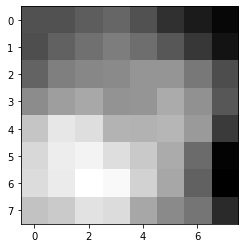

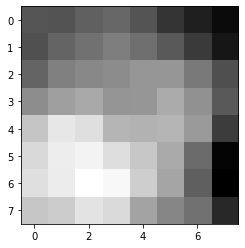

In [1103]:
print(all_patches[0].shape)
a = sparse_codes[0] @ dict.T
# print(np.count_zero(a == all_patches[0].T))

(192, 16)


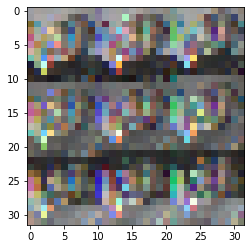

In [1105]:
sc0 = preds[0].reshape(16, 64)
print(sc0)

In [1105]:
print(dict.shape)

In [1106]:
patches_reconstructed = dict @ sc0.T
print(patches_reconstructed.shape)

In [1107]:
reconstruction = patches2FullImage(patches_reconstructed)

(192, 64)


In [1108]:
reco = vec2RGB(reconstruction)
print(reco.shape)
plt.imshow(reco)
plt.show()

In [1109]:
sparse_codes = np.array(sparse_codes)
sparse_codes_flattened = np.array(sparse_codes_flattened)

print(sparse_codes[1].shape)
print(dict.shape)

# r = sparse_codes[1] @ dict.T
# r = np.dot(sparse_codes[0], dict.T)
# print(r.shape)
# r2 = patches2FullImage(r.T)
# print(r2.shape)

# plt.imshow(vec2RGB(r2))

In [1110]:
print(all_patches[0].shape)
a = sparse_codes[0] @ dict.T
# print(np.count_zero(a == all_patches[0].T))

In [1111]:

true = vec2RGB(patches2FullImage(a.T))
plt.imshow(true)

(16, 64)
(192, 64)
(16, 192)
(3072,)


TypeError: only size-1 arrays can be converted to Python scalars